In [23]:
import cdsapi
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress

### Optional: Download data

In [4]:
# Download data from CDS
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "vertical_integral_of_eastward_water_vapour_flux",
        "vertical_integral_of_northward_water_vapour_flux",
        "vertically_integrated_moisture_divergence"
    ],
    "year": [
        "1980", "1981", "1982",
        "1983", "1984", "1985",
        "1986", "1987", "1988",
        "1989", "1990", "1991",
        "1992", "1993", "1994",
        "1995", "1996", "1997",
        "1998", "1999", "2000",
        "2001", "2002", "2003",
        "2004", "2005", "2006",
        "2007", "2008", "2009",
        "2010", "2011", "2012",
        "2013", "2014", "2015",
        "2016", "2017", "2018",
        "2019", "2020", "2021",
        "2022"
    ],
    "month": ["03", "04", "05"],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [90, -180, 0, 180]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-08-29 12:05:04,846 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-29 12:05:05,513 INFO Request ID is f41a69a8-9615-43b9-8b17-0846187d5525
2025-08-29 12:05:05,790 INFO status has been updated to accepted
2025-08-29 12:05:15,027 INFO status has been updated to running
2025-08-29 12:05:28,188 INFO status has been updated to accepted
2025-08-29 12:06:23,056 INFO status has been updated to running
2025-08-29 12:07:01,753 INFO status has been updated to successful


a455bc65264790c0202b43a076812868.zip:   0%|          | 0.00/304M [00:00<?, ?B/s]

'a455bc65264790c0202b43a076812868.zip'

### Analysis

In [20]:
# Load datasets
ds_flux = xr.open_dataset('./data/moisture_flux.nc')
ds_div = xr.open_dataset('./data/moisture_divergence.nc')

# Rename 'valid_time' to 'time' for convenience
ds_flux = ds_flux.rename({'valid_time': 'time'})
ds_div = ds_div.rename({'valid_time': 'time'})

# Group by month and compute climatology
flux_clim = ds_flux.groupby('time.month').mean('time')
div_clim = ds_div.groupby('time.month').mean('time')

# Group by year-month and compute anomalies
flux_anom = ds_flux.groupby('time.month') - flux_clim
div_anom = ds_div.groupby('time.month') - div_clim

flux_anom

<xarray.Dataset> Size: 536MB
Dimensions:    (time: 129, latitude: 361, longitude: 1440)
Coordinates:
    number     (time) int64 1kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * time       (time) datetime64[ns] 1kB 1980-03-01 1980-04-01 ... 2022-05-01
  * latitude   (latitude) float64 3kB 90.0 89.75 89.5 89.25 ... 0.5 0.25 0.0
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    expver     (time) <U4 2kB '0001' '0001' '0001' ... '0001' '0001' '0001'
    month      (time) int64 1kB 3 4 5 3 4 5 3 4 5 3 4 ... 4 5 3 4 5 3 4 5 3 4 5
Data variables:
    viwve      (time, latitude, longitude) float32 268MB 0.2903 0.2903 ... 14.77
    viwvn      (time, latitude, longitude) float32 268MB -0.3159 ... 25.7

In [32]:
def compute_flux_trend_quiver(ds, u_var, v_var, month):
    # Filter for a specific month
    ds_month = ds.sel(time=ds.time.dt.month == month)

    # Time vector for regression (0 to N)
    years = ds_month.time.dt.year
    x = (years - years.min()).values

    def linreg(y):
        slope, _, _, _, _ = linregress(x, y)
        return slope * 10  # Trend per decade

    # Apply to u (eastward)
    u_trend = xr.apply_ufunc(
        linreg, ds_month[u_var],
        input_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )

    # Apply to v (northward)
    v_trend = xr.apply_ufunc(
        linreg, ds_month[v_var],
        input_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )

    return u_trend, v_trend


def compute_monthly_trend(ds, varname, month):
    # Select month
    ds_month = ds.sel(time=ds['time'].dt.month == month)

    # Get time in years
    years = ds_month['time'].dt.year
    x = years - years.min()  # e.g., 0 to 42

    # Apply regression to each grid point
    def linreg(y):
        slope, _, _, p, _ = linregress(x, y)
        return slope * 10  # per decade

    trend = xr.apply_ufunc(
        linreg,
        ds_month[varname],
        input_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )

    return trend


/global/homes/s/skygale/.conda/envs/Sweeneyetal2023/lib/python3.9/site-packages/cartopy/crs.py:545: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '
/global/homes/s/skygale/.conda/envs/Sweeneyetal2023/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


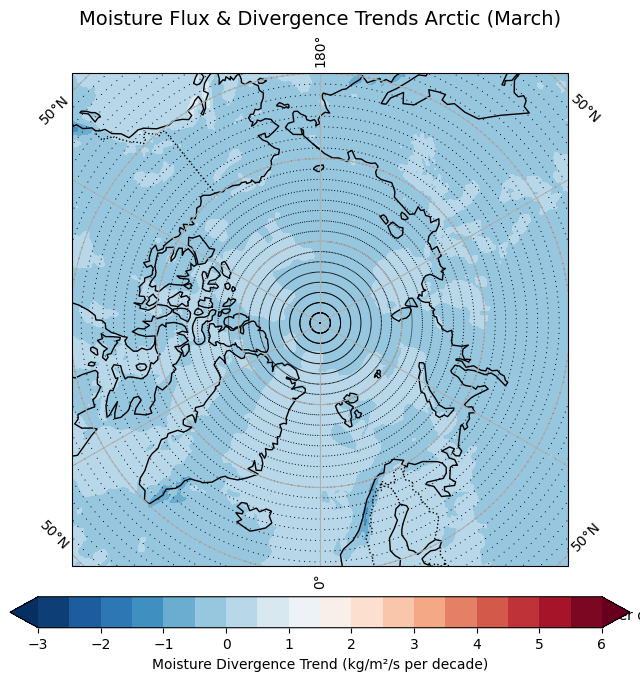

KeyboardInterrupt: 

In [33]:
for m in months:
    u_trend, v_trend = compute_flux_trend_quiver(ds_flux, 'viwve', 'viwvn', m)
    vimd_trend = compute_monthly_trend(ds_div, 'vimd', m)
    

In [ ]:
def plot_flux_trend_with_divergence_polar(u, v, div, title, stride=5, scale=1e7):
    # Coordinates (lat/lon)
    lons = u['longitude']
    lats = u['latitude']
    Lon, Lat = np.meshgrid(lons, lats)

    # Subsample vectors for quiver
    u_ = u.values[::stride, ::stride]
    v_ = v.values[::stride, ::stride]
    Lon_ = Lon[::stride, ::stride]
    Lat_ = Lat[::stride, ::stride]

    # Define projection objects
    data_crs = ccrs.PlateCarree()  # your data coordinate system (lat/lon)
    proj = ccrs.NorthPolarStereo()

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': proj})
    ax.set_title(title, fontsize=14)

    # Set extent to focus on Arctic (lon_min, lon_max, lat_min, lat_max)
    ax.set_extent([-180, 180, 60, 90], crs=data_crs)

    # Add background features
    ax.coastlines(resolution='110m')
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Contourf for divergence trend
    div_plot = ax.contourf(
        Lon, Lat, div,
        levels=21, cmap='RdBu_r',
        transform=data_crs,
        extend='both'
    )
    cbar = plt.colorbar(div_plot, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Moisture Divergence Trend (kg/m²/s per decade)')

    # Quiver plot for moisture flux trend
    q = ax.quiver(
        Lon_, Lat_, u_, v_,
        scale=scale, color='black',
        transform=data_crs
    )
    plt.quiverkey(q, 0.9, -0.1, 1e7, '1e7 kg/m/s per decade', labelpos='E')

    plt.show()


In [ ]:
plot_flux_trend_with_divergence_polar(
        u_trend, v_trend, vimd_trend,
        title=f"Moisture Flux & Divergence Trends Arctic ({months[m]})"
    )